In [1]:
cd /home/users/cdonoso/astromer/ASTROMER/

/home/users/cdonoso/astromer/ASTROMER


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os

from core.data import pretraining_records
from sklearn.metrics import precision_recall_fscore_support
from presentation.scripts.backprop import NormedLSTMCell
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Something GPU-related is solved when using the following lines.
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

%load_ext autoreload
%autoreload 2

In [3]:
dataset_name = 'alcock'
num_cls = pd.read_csv(os.path.join('./data/records/{}/fold_0/{}/'.format(dataset_name, dataset_name), 'objects.csv')).shape[0]

In [4]:
test_ds = pretraining_records(os.path.join('./data/records/{}/fold_0/{}/'.format(dataset_name,dataset_name), 'test/'),
                     1000, max_obs=200, msk_frac=0., rnd_frac=0., same_frac=0.,
                     sampling=False, shuffle=False,
                     n_classes=num_cls)
y_true = np.concatenate([np.argmax(y, 1) for _, y in test_ds])

2021-12-11 13:28:59.069408: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-11 13:28:59.453242: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22355 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:81:00.0, compute capability: 8.6


[INFO] Processing labels


2021-12-11 13:29:00.643949: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
def get_prediction(data, folder):
    model = tf.keras.models.load_model(folder, custom_objects={'NormedLSTMCell':NormedLSTMCell})
    y_pred = model.predict(data)
    y_pred = tf.argmax(y_pred, 1)
    return y_pred

In [6]:
folds_df = []
for fold_n in range(3):
    results = []
    for model_name in ['lstm', 'lstm_att', 'mlp_att']:
        y_pred = get_prediction(test_ds, './experiments_6/{}/fold_{}/{}/{}/model/'.format(dataset_name, 
                                                                                          fold_n, 
                                                                                          dataset_name, model_name))
        prec, reca, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
        results.append([dataset_name, model_name, f1, prec, reca])
        
    df_results = pd.DataFrame(results, columns=['exp', 'model', 'f1', 'recall', 'precision'])
    df_results['fold'] = [fold_n]*df_results.shape[0]
    folds_df.append(df_results)

2021-12-11 13:29:05.548706: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-12-11 13:29:06.139440: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-12-11 13:29:08.166364: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-11 13:29:08.691152: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-11 13:29:09.318398: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-11 13:29:09.508378: W tensorflow/core/common_runtime/graph_

2021-12-11 13:29:30.537709: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-11 13:29:30.550093: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-11 13:29:30.752867: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-11 13:29:31.348256: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-11 13:29:31.735774: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_sh

2021-12-11 13:29:52.494877: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-11 13:29:52.940918: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-11 13:29:52.953444: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


In [7]:
pd.concat(folds_df, 0).groupby('model').mean()

/tmp/ipykernel_425894/644615393.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  pd.concat(folds_df, 0).groupby('model').mean()


,f1,recall,precision,fold
model,,,,
lstm,0.772414,0.772984,0.772895,1.0
lstm_att,0.840241,0.839998,0.841866,1.0
mlp_att,0.588879,0.638940,0.577573,1.0


In [13]:
# y_true = tf.concat([tf.argmax(y, 1) for _, y in ds], 0)

In [7]:
dataset_name = 'alcock'

In [8]:
%%time
for fold_n in range(3):
    results = []
    for dataset in ['{}_20'.format(dataset_name),
                    '{}_50'.format(dataset_name), 
                    '{}_100'.format(dataset_name), 
                    '{}_500'.format(dataset_name)]:
        ds_path = './data/records/{}/fold_{}/{}/'.format(dataset_name, fold_n, dataset)
        test_ds = pretraining_records(os.path.join(ds_path, 'test/'),
                             1000, max_obs=200, msk_frac=0., rnd_frac=0., same_frac=0.,
                                        sampling=False, shuffle=False,
                                        n_classes=num_cls)
        y_true = np.concatenate([np.argmax(y, 1) for _, y in test_ds])
        for model_name in ['lstm', 'lstm_att', 'mlp_att']:
            path = './experiments_6/{}/fold_{}/{}/'.format(dataset_name, fold_n, dataset)
            y_pred = get_prediction(test_ds, os.path.join(path, model_name, 'model'))

            prec, reca, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            results.append([dataset, model_name, f1, prec, reca])
            
    df_results = pd.DataFrame(results, columns=['exp', 'model', 'f1', 'recall', 'precision'])
    df_results.to_csv('./experiments_6/{}/results_{}.csv'.format(dataset_name, fold_n), index=False)

[INFO] Processing labels


2021-12-10 17:10:31.101980: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-12-10 17:10:31.704129: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-12-10 17:10:33.726105: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:10:34.515973: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:10:34.528851: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-12-10 17:10:35.668098: W tensorflow/core/common_runtime/graph_constru

[INFO] Processing labels


2021-12-10 17:10:50.943039: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:10:50.956449: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-12-10 17:10:51.098192: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:10:51.380138: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:10:51.392548: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

[INFO] Processing labels


2021-12-10 17:11:07.593874: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:07.630772: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:07.733478: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:08.353087: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:08.365601: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

[INFO] Processing labels


2021-12-10 17:11:23.528423: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:23.961586: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:24.561074: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:24.912824: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:24.993841: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _ou

[INFO] Processing labels


2021-12-10 17:11:39.837479: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:39.958230: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:40.377121: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:40.730770: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:41.975439: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _ou

[INFO] Processing labels


2021-12-10 17:11:56.741128: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:57.176682: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:57.573628: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:57.857506: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:11:57.870725: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

[INFO] Processing labels


2021-12-10 17:12:13.441591: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:12:14.057296: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:12:14.078438: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-12-10 17:12:14.129024: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-12-10 17:12:14.143784: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_sh

[INFO] Processing labels


2021-12-10 17:12:30.160342: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:12:31.712369: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:12:31.802802: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-12-10 17:12:31.839005: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:12:31.851271: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

[INFO] Processing labels


2021-12-10 17:12:47.190312: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:12:47.271527: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:12:47.288250: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:12:47.559819: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-12-10 17:12:48.547027: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _ou

[INFO] Processing labels


2021-12-10 17:13:03.314127: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:13:03.728398: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-12-10 17:13:03.771943: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:13:03.925663: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:13:04.432252: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

[INFO] Processing labels


2021-12-10 17:13:20.623717: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:13:21.220811: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:13:21.790889: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-12-10 17:13:22.114972: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:13:22.291465: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _ou

[INFO] Processing labels


2021-12-10 17:13:37.818825: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:13:37.954278: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:13:37.966945: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-12-10 17:13:39.033901: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-12-10 17:13:39.047102: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

CPU times: user 3min 28s, sys: 8.19 s, total: 3min 36s
Wall time: 3min 21s


In [10]:
fold_0 = pd.read_csv('./experiments_7/alcock/results_0.csv')
fold_1 = pd.read_csv('./experiments_7/alcock/results_1.csv')
fold_2 = pd.read_csv('./experiments_7/alcock/results_2.csv')

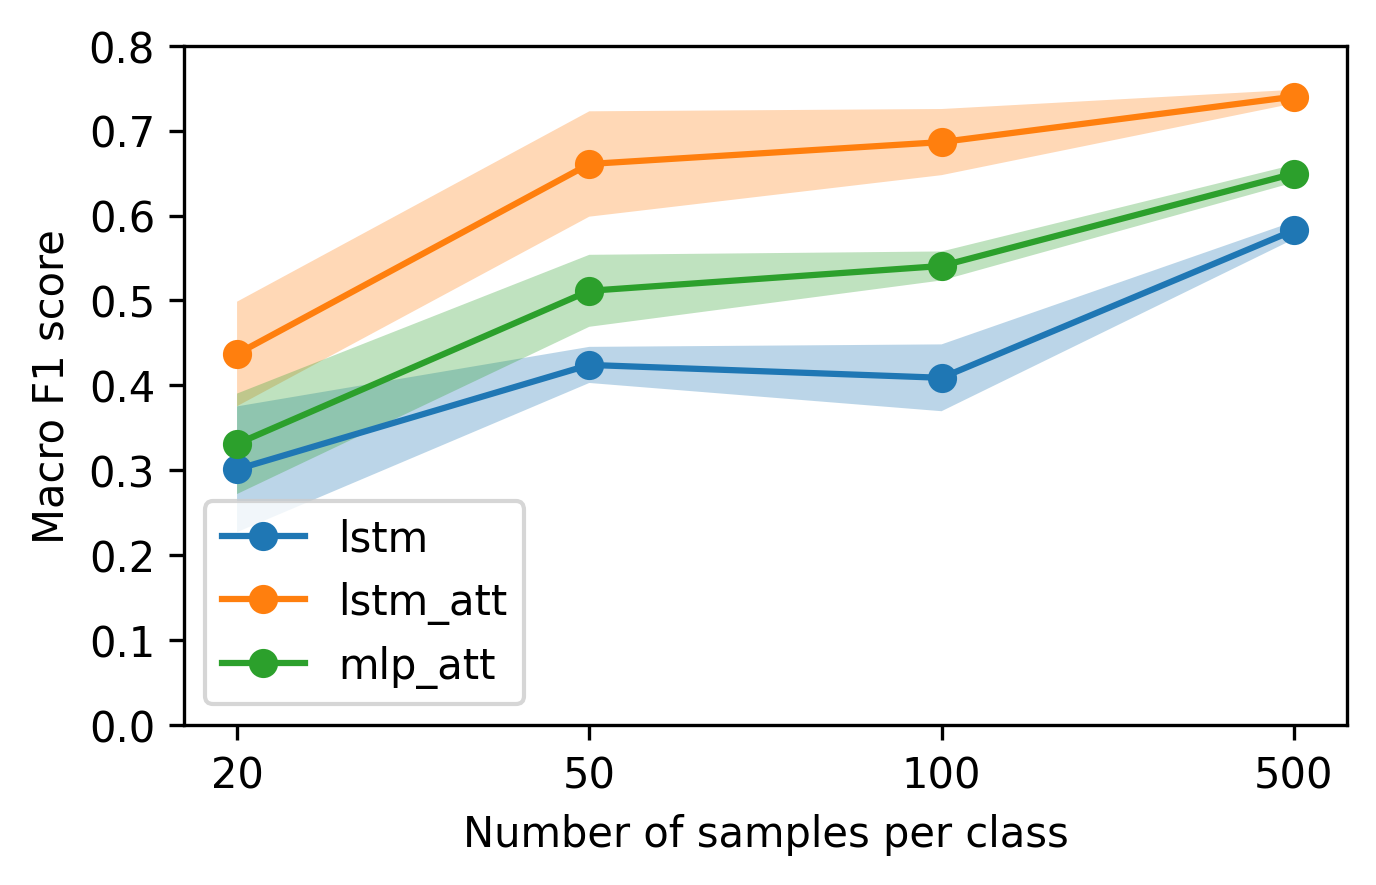

In [12]:
plt.figure(figsize=(5,3), dpi=300)
for (exp0, g0), (exp1, g1), (exp2, g2) in zip(fold_0.groupby('model'), fold_1.groupby('model'), fold_2.groupby('model')):
    
    f1_mean = np.mean([g0['f1'][:], g1['f1'][:], g2['f1'][:]], 0)
    f1_std = np.std([g0['f1'][:], g1['f1'][:], g2['f1'][:]], 0)

    xrange = range(len(g0['exp'][:]))    
    plt.plot(xrange, f1_mean, marker='o',label=exp0)
    plt.fill_between(xrange, f1_mean+f1_std, f1_mean-f1_std, alpha=0.3)
    plt.xticks(xrange, [x.split('_')[-1] for x in g0['exp'][:]])

plt.ylim(0, 0.8)
plt.ylabel('Macro F1 score')
plt.xlabel('Number of samples per class')
plt.legend()#loc='lower right')
plt.show()

In [11]:
from tensorboard.backend.event_processing import event_accumulator
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)
def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

In [22]:
exp_folder = './experiments_6/ogle/fold_1/ogle_100/'

dict_keys(['epoch_loss', 'epoch_accuracy'])
dict_keys(['epoch_loss', 'epoch_accuracy'])
dict_keys(['epoch_loss', 'epoch_accuracy'])


Text(0.0, 0.5, 'Categorical Cross Entropy')

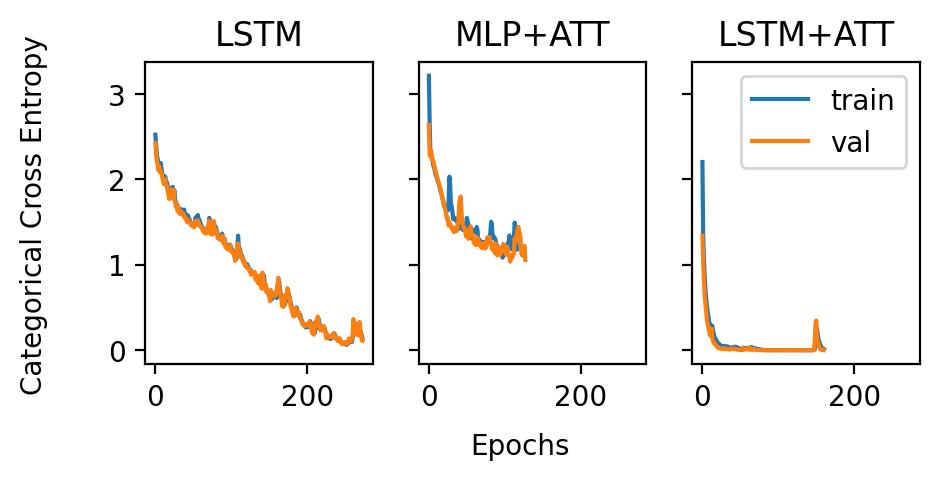

In [23]:
fig, axes = plt.subplots(1,3, sharey=True,sharex=True, figsize=(5,2), dpi=200, 
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},)
for index, name in enumerate(['lstm', 'mlp_att', 'lstm_att']):
#     if name != 'lstm':continue
    val_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'validation'))
    train_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'train'))
    print(train_metrics.keys())
    axes[index].plot(train_metrics['epoch_loss'], label='train')
    axes[index].plot(val_metrics['evaluation_loss_vs_iterations'], label='val')
    if name =='lstm': title_name = 'LSTM'
    if name =='mlp_att': title_name = 'MLP+ATT'
    if name =='lstm_att': title_name = 'LSTM+ATT'
    axes[index].set_title(title_name)
    
#     axes[index].set_yscale('log')

axes[-1].legend()
fig.text(0.5, -0.1, 'Epochs', ha='center')
fig.text(0.0, 0.5, 'Categorical Cross Entropy', va='center', rotation='vertical')